# Overview

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Workflow 
1. Load Data
2. Data Wrangling
2. EDA
3. Modeling
4. Deployment

In [3]:
# Data Wrangling
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Data Imputation
from sklearn.impute import KNNImputer

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer

# Modeling
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Validation
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, make_scorer


# Load Data

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Columns Definition
- PassengerId: Unique identifier for each passenger
- Survived: Survival status (0 = No, 1 = Yes)
- Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Name: Passenger's name
- Sex: Gender
- Age: Age of the passenger
- SibSp: Number of siblings or spouses aboard the Titanic
- Parch: Number of parents or children aboard the Titanic
- Ticket: Ticket number
- Fare: Passenger fare
- Cabin: Cabin number
- Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
print(train_df.PassengerId.nunique())

891


In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [10]:
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


**Remarks.**
- Needs to understand why a lot of age data is missing
- I think there's a correlation between fare and non-null value cabin, as the higher the fare amounts the more likely include the cabin

In [11]:
train_df.query("Age.isna()").describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,177.000000,177.000000,177.000000,0.0,177.000000,177.000000,177.000000
mean,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567
std,250.552901,0.456787,0.763216,NaN,1.626316,0.534145,31.874608
min,6.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000
25%,230.000000,0.000000,3.000000,NaN,0.000000,0.000000,7.750000
50%,452.000000,0.000000,3.000000,NaN,0.000000,0.000000,8.050000
75%,634.000000,1.000000,3.000000,NaN,0.000000,0.000000,24.150000
max,889.000000,1.000000,3.000000,NaN,8.000000,2.000000,227.525000


In [12]:
train_df.query("~Age.isna()").describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
std,259.119524,0.491460,0.838250,14.526497,0.929783,0.853289,52.918930
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.250000,0.000000,1.000000,20.125000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.741700
75%,677.750000,1.000000,3.000000,38.000000,1.000000,1.000000,33.375000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


- Create inputation model to predict the age based on  Pclass, Age, and Fare

## Data Wrangling

### Age Imputation

In [13]:
train_df_processed = train_df.copy()
test_df_processed = test_df.copy()

In [14]:
age_imputer = KNNImputer(n_neighbors=2)
age_imputer.fit(train_df_processed[['Pclass', 'Fare','SibSp', 'Parch', 'Age']])

train_df_processed['Age'] = age_imputer.transform(train_df_processed[['Pclass', 'Fare','SibSp', 'Parch', 'Age']])[:, -1]
test_df_processed['Age'] = age_imputer.transform(test_df_processed[['Pclass', 'Fare','SibSp', 'Parch', 'Age']])[:, -1]

c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

### Fare Imputation

In [15]:
train_df_processed['Fare'] = train_df_processed.Fare.fillna(train_df_processed.Fare.median())
test_df_processed['Fare'] = test_df_processed.Fare.fillna(test_df_processed.Fare.median())

### Cabin Feature

In [16]:
train_df_processed['has_cabin'] = ~train_df_processed.Cabin.isna() * 1
test_df_processed['has_cabin'] = ~test_df_processed.Cabin.isna() * 1

In [17]:
train_df_processed.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [18]:
train_df_processed.groupby('has_cabin').Fare.mean()

has_cabin
0    19.157325
1    76.141504
Name: Fare, dtype: float64

### Title Feature

In [19]:
train_df_processed['Title'] = train_df_processed.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
test_df_processed['Title'] = test_df_processed.Name.str.split(',').str[1].str.split('.').str[0].str.strip()

In [20]:
train_df_processed.Title.value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [21]:
test_df_processed.Title.value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [22]:
train_df_processed['Title'] = train_df_processed.Title.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')
test_df_processed['Title'] = test_df_processed.Title.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')

In [23]:
train_df_processed[["Title", "Survived"]].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.792000
1,Miss,0.697802
0,Master,0.575000
4,Other,0.444444
2,Mr,0.156673


### Embarked Imputation

In [24]:
train_df_processed.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [25]:
train_df_processed.Embarked.fillna('S', inplace=True)
test_df_processed.Embarked.fillna('S', inplace=True)

In [26]:
train_df_processed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Other
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,33.0,1,2,W./C. 6607,23.4500,NaN,S,0,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,Mr


### Sex Encoding

In [27]:
train_df_processed['Sex_en'] = train_df_processed.Sex.map({'male':0, 'female':1})
test_df_processed['Sex_en'] = test_df_processed.Sex.map({'male':0, 'female':1})

## Visualization

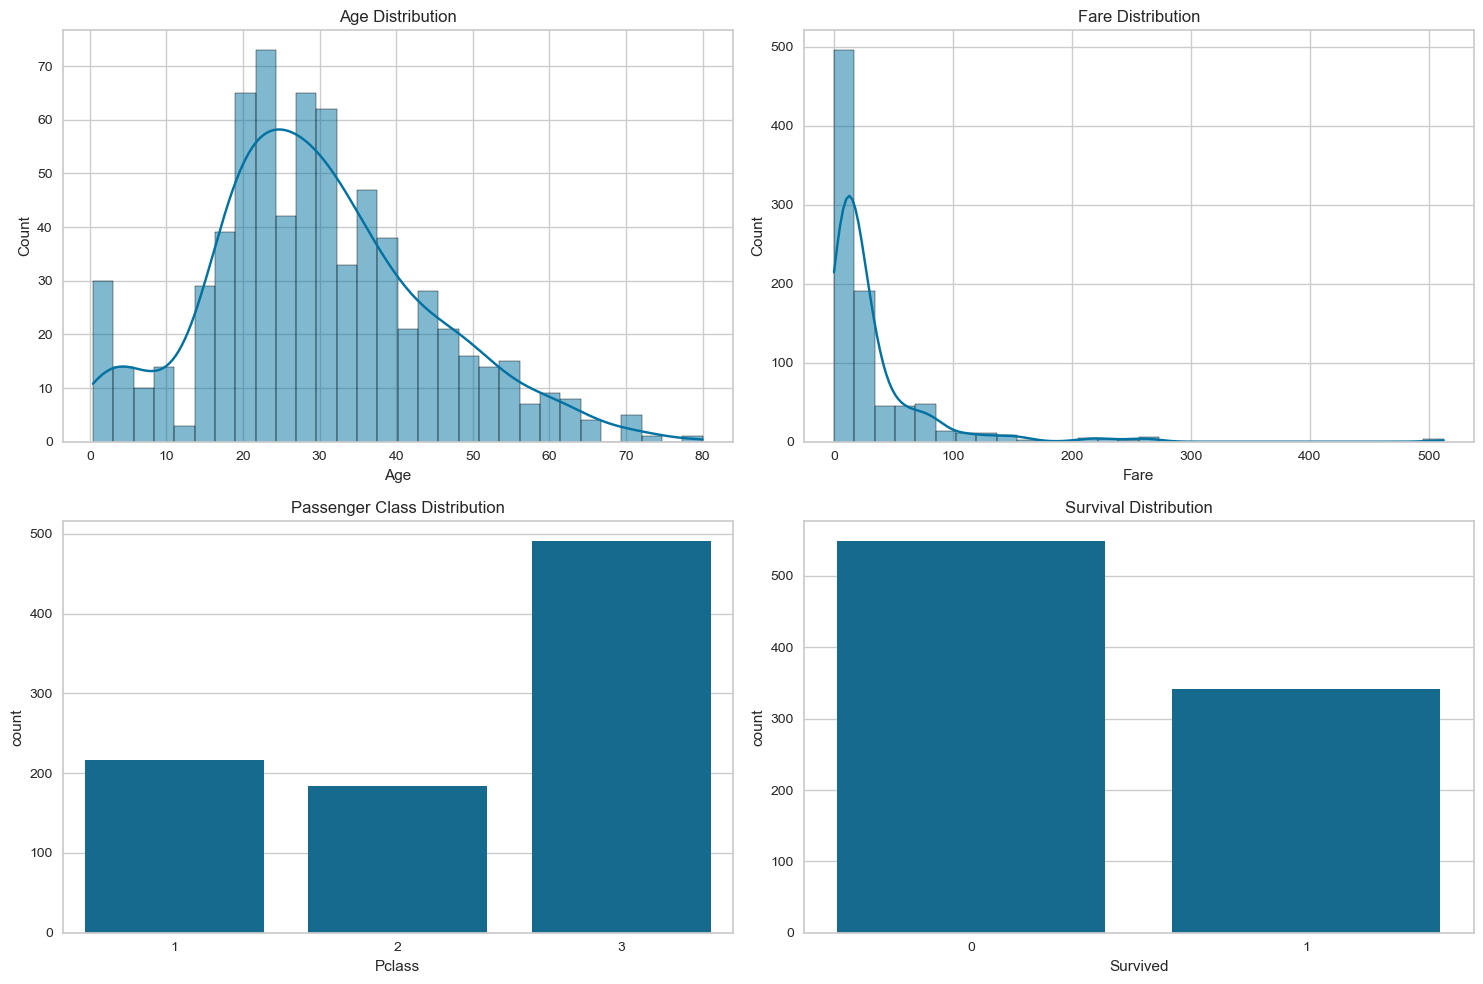

In [27]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot the distribution of Age
plt.subplot(2, 2, 1)
sns.histplot(train_df['Age'].dropna(), kde=True, bins=30)
plt.title('Age Distribution')

# Plot the distribution of Fare
plt.subplot(2, 2, 2)
sns.histplot(train_df['Fare'], kde=True, bins=30)
plt.title('Fare Distribution')

# Plot the count of passengers by class
plt.subplot(2, 2, 3)
sns.countplot(x='Pclass', data=train_df)
plt.title('Passenger Class Distribution')

# Plot the count of survivors
plt.subplot(2, 2, 4)
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Distribution')

plt.tight_layout()
plt.show()


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<Axes: >

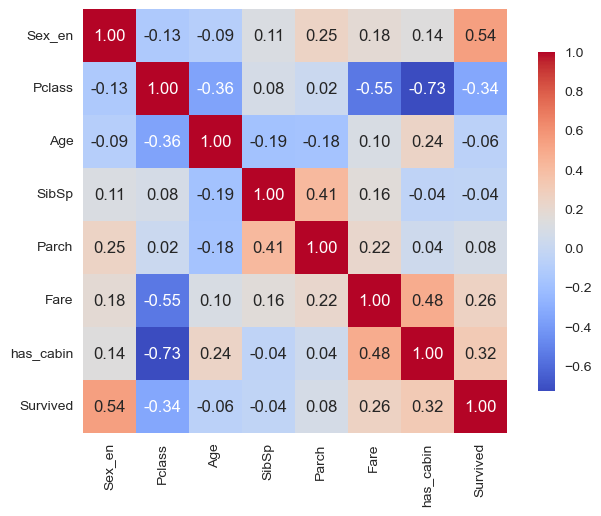

In [30]:
corr = train_df_processed[['Sex_en', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'has_cabin','Survived']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})

## Pivot Analysis

In [31]:
train_df_processed[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [32]:
train_df_processed[['has_cabin', 'Survived']].groupby(['has_cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,has_cabin,Survived
1,1,0.666667
0,0,0.299854


In [33]:
train_df_processed[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [34]:
train_df_processed[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.792000
1,Miss,0.697802
0,Master,0.575000
4,Other,0.444444
2,Mr,0.156673


# Cluster Analysis

In [28]:
feature_list = ['Sex_en', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'has_cabin']
features = train_df_processed[feature_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

In [29]:
scaled_features

array([[-0.73769513,  0.82737724, -0.60403706, ..., -0.47367361,
        -0.50244517, -0.54492498],
       [ 1.35557354, -1.56610693,  0.55710121, ..., -0.47367361,
         0.78684529,  1.835115  ],
       [ 1.35557354,  0.82737724, -0.31375249, ..., -0.47367361,
        -0.48885426, -0.54492498],
       ...,
       [ 1.35557354,  0.82737724,  0.1942455 , ...,  2.00893337,
        -0.17626324, -0.54492498],
       [-0.73769513, -1.56610693, -0.31375249, ..., -0.47367361,
        -0.04438104,  1.835115  ],
       [-0.73769513,  0.82737724,  0.12167436, ..., -0.47367361,
        -0.49237783, -0.54492498]])

### KMEeans

c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

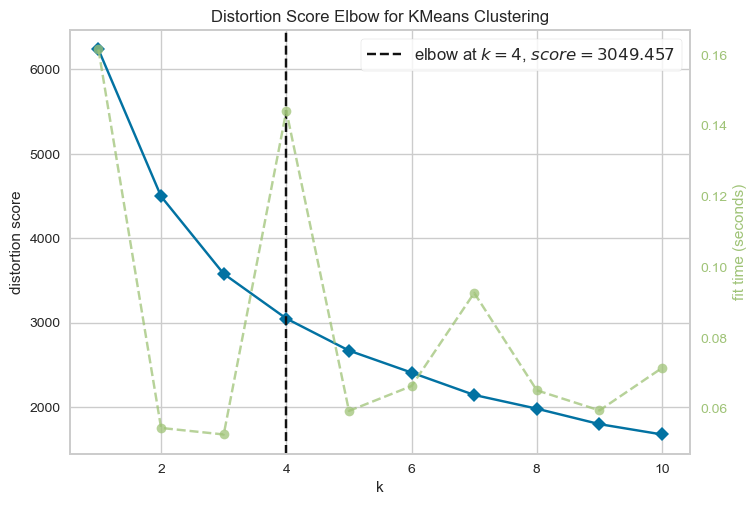

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(scaled_features)        # Fit the data to the visualizer
visualizer.show()


In [38]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)

c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [39]:
features['kmeans_label'] = kmeans.predict(scaled_features)

C:\Users\Bana\AppData\Local\Temp\ipykernel_23556\3766940550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['kmeans_label'] = kmeans.predict(scaled_features)


### DBSCSAN

In [40]:
dbscan = DBSCAN(eps=0.1)
dbscan.fit(scaled_features)

features['dbscan_label'] = dbscan.labels_
features['dbscan_label'] = features.dbscan_label.apply(lambda x: 100 if x < 0 else x)
features['Survived'] = train_df_processed['Survived']

C:\Users\Bana\AppData\Local\Temp\ipykernel_23556\1340542947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['dbscan_label'] = dbscan.labels_
C:\Users\Bana\AppData\Local\Temp\ipykernel_23556\1340542947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['dbscan_label'] = features.dbscan_label.apply(lambda x: 100 if x < 0 else x)
C:\Users\Bana\AppData\Local\Temp\ipykernel_23556\1340542947.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [41]:
features.columns

Index(['Sex_en', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'has_cabin',
       'kmeans_label', 'dbscan_label', 'Survived'],
      dtype='object')

In [42]:
features.groupby('dbscan_label').mean()

,Sex_en,Pclass,Age,SibSp,Parch,Fare,has_cabin,kmeans_label,Survived
dbscan_label,,,,,,,,,
0,1.000000,3.0000,23.810000,0.000000,0.000000,8.041008,0.000000,1.000000,0.560000
1,0.000000,3.0000,25.244737,0.000000,0.000000,8.097582,0.000000,0.000000,0.105263
2,1.000000,3.0000,15.200000,0.000000,0.000000,7.718340,0.000000,1.000000,0.800000
3,0.000000,3.0000,42.500000,0.000000,0.000000,7.637082,0.000000,0.000000,0.100000
4,1.000000,3.0000,46.111111,0.000000,0.000000,7.750000,0.000000,1.000000,0.777778
5,1.000000,3.0000,18.285714,0.000000,0.000000,7.887500,0.000000,1.000000,0.714286
6,0.000000,2.0000,26.875000,0.000000,0.000000,12.272742,0.000000,0.000000,0.041667
7,0.000000,2.0000,18.500000,0.000000,0.000000,11.666667,0.000000,0.000000,0.166667
8,0.000000,2.0000,34.531250,0.000000,0.000000,12.540625,0.000000,0.000000,0.125000


## PCA

In [43]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Survived'] = train_df_processed['Survived']
principal_df['dbscan_label'] = features['dbscan_label']
principal_df['kmeans_label'] = features['kmeans_label']

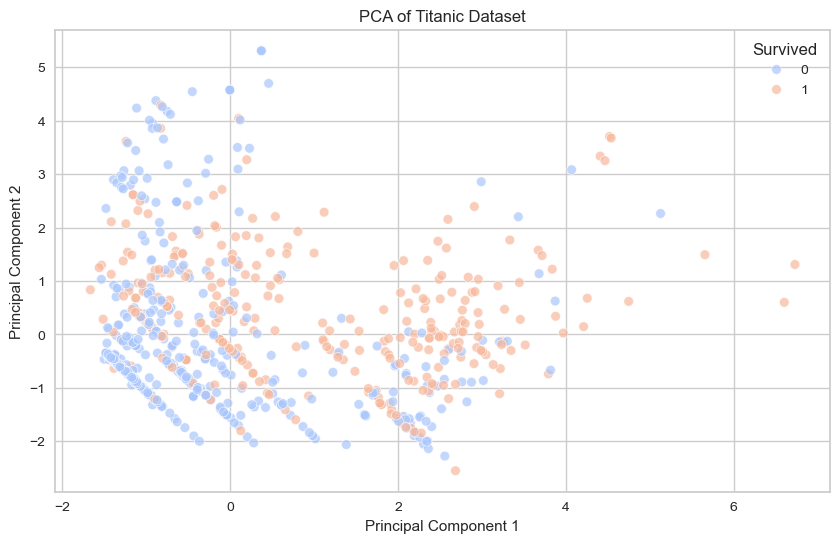

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='Survived', palette='coolwarm', alpha=0.7)
plt.title('PCA of Titanic Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Survived')
plt.show()

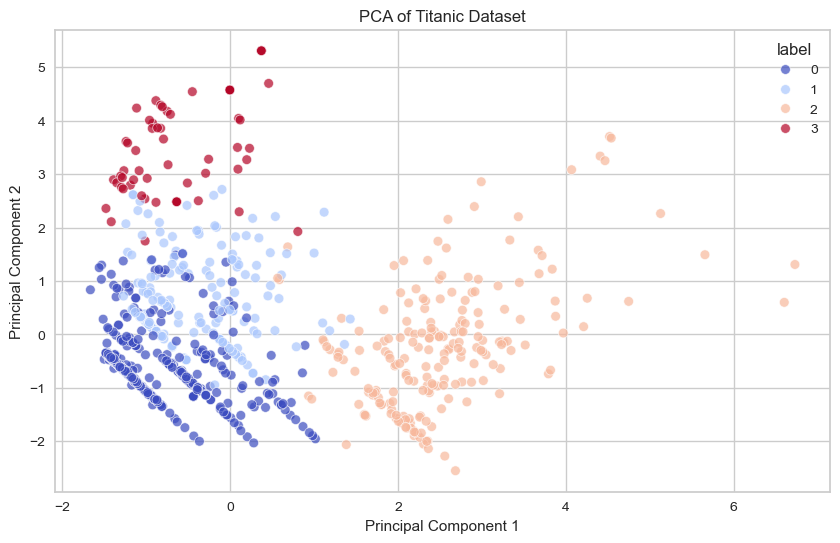

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='kmeans_label', palette='coolwarm', alpha=0.7)
plt.title('PCA of Titanic Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='label')
plt.show()

In [46]:
features.groupby('kmeans_label').mean()

,Sex_en,Pclass,Age,SibSp,Parch,Fare,has_cabin,dbscan_label,Survived
kmeans_label,,,,,,,,,
0,0.000000,2.670429,30.038375,0.207675,0.103837,13.471724,0.013544,39.534989,0.142212
1,1.000000,2.598930,25.875455,0.438503,0.454545,17.328232,0.037433,70.566845,0.716578
2,0.480392,1.073529,37.823137,0.441176,0.401961,85.430414,0.936275,100.000000,0.676471
3,0.508772,2.964912,20.289474,3.543860,2.228070,36.101611,0.000000,100.000000,0.122807


In [49]:
features.kmeans_label.value_counts()

kmeans_label
0    443
2    204
1    187
3     57
Name: count, dtype: int64

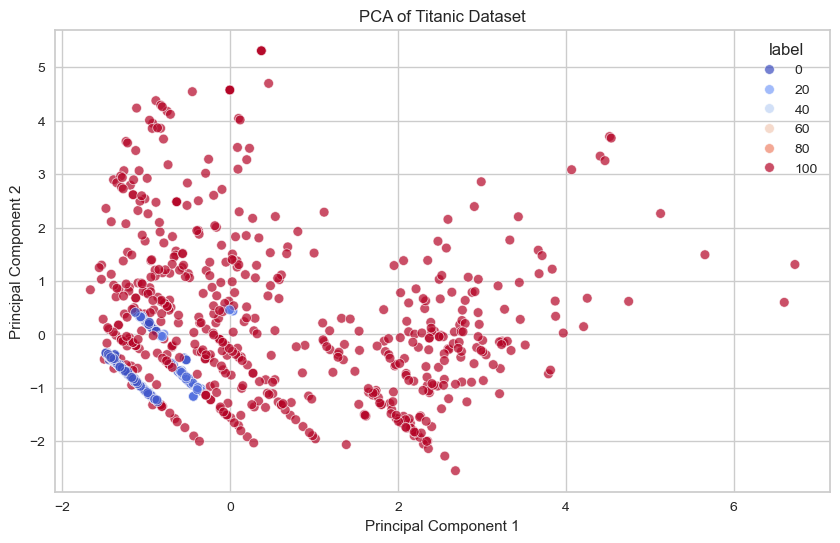

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='dbscan_label', palette='coolwarm', alpha=0.7)
plt.title('PCA of Titanic Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='label')
plt.show()

## Adding kmeans label to features

In [31]:
train_df_processed['kmeans_label'] = kmeans.predict(train_df_processed[feature_list])
test_df_processed['kmeans_label'] = kmeans.predict(test_df_processed[feature_list])

c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd

# Modeling

## Preprocessing

In [32]:
X = train_df_processed.drop(['PassengerId', 'Survived', 'Ticket', 'Cabin', 'Name', 'Sex'], axis=1)
y = train_df_processed.Survived.values

In [33]:
X['Embarked'] = pd.Categorical(X['Embarked'])
X['Title'] = pd.Categorical(X['Title'])

## Create Scoring Dict

In [90]:
scoring_dict = {'f1_score':make_scorer(f1_score),
                'precision': make_scorer(precision_score),
                'recall_score': make_scorer(recall_score),
                'roc_auc_score': make_scorer(roc_auc_score)}

In [91]:
def summarize_metrics(metrics):
    summary = {}
    for key, values in metrics.items():
        summary[key] = {
            'mean': np.mean(values),
            'median': np.median(values),
            'std': np.std(values)
        }
    return pd.DataFrame(summary)

## LGBM

### Fitting and Crossvalidate

In [92]:
lgbm_model = LGBMClassifier(random_state=42)

lgbm_model_score = cross_validate(lgbm_model, X, y, scoring=scoring_dict)

## XGBoost

### Fitting and Crossvalidate

## Visualization

In [94]:
xgb_model = XGBClassifier(enable_categorical=True, random_state=42)

xgb_model_score = cross_validate(xgb_model, X, y, scoring=scoring_dict)

In [97]:
cat_model = CatBoostClassifier(cat_features=[0, 5, 7, 9], random_state=42)

cat_model_score = cross_validate(cat_model, X, y, scoring=scoring_dict)

Learning rate set to 0.008911
0:	learn: 0.6870922	total: 188ms	remaining: 3m 8s
1:	learn: 0.6811832	total: 230ms	remaining: 1m 55s
2:	learn: 0.6759068	total: 264ms	remaining: 1m 27s
3:	learn: 0.6696738	total: 315ms	remaining: 1m 18s
4:	learn: 0.6641270	total: 353ms	remaining: 1m 10s
5:	learn: 0.6583489	total: 394ms	remaining: 1m 5s
6:	learn: 0.6532867	total: 434ms	remaining: 1m 1s
7:	learn: 0.6476947	total: 471ms	remaining: 58.4s
8:	learn: 0.6440052	total: 510ms	remaining: 56.2s
9:	learn: 0.6391284	total: 547ms	remaining: 54.1s
10:	learn: 0.6347816	total: 584ms	remaining: 52.5s
11:	learn: 0.6307814	total: 609ms	remaining: 50.1s
12:	learn: 0.6263104	total: 647ms	remaining: 49.1s
13:	learn: 0.6208171	total: 684ms	remaining: 48.2s
14:	learn: 0.6163808	total: 730ms	remaining: 47.9s
15:	learn: 0.6117722	total: 768ms	remaining: 47.2s
16:	learn: 0.6079390	total: 800ms	remaining: 46.3s
17:	learn: 0.6042344	total: 838ms	remaining: 45.7s
18:	learn: 0.6006049	total: 870ms	remaining: 44.9s
19:	lea

In [102]:
print("LGBM Score")
display(summarize_metrics(lgbm_model_score))
print("XGboost Score")
display(summarize_metrics(xgb_model_score))
print("Catboost Score")
display(summarize_metrics(cat_model_score))

LGBM Score


,fit_time,score_time,test_f1_score,test_precision,test_recall_score,test_roc_auc_score
mean,0.080828,0.010828,0.745847,0.762955,0.730776,0.795254
median,0.086531,0.011024,0.768116,0.768116,0.768116,0.810663
std,0.009927,0.000396,0.049572,0.029344,0.068185,0.037864


XGboost Score


,fit_time,score_time,test_f1_score,test_precision,test_recall_score,test_roc_auc_score
mean,0.084953,0.011833,0.742349,0.759590,0.727792,0.791911
median,0.073739,0.012025,0.755245,0.731343,0.750000,0.799561
std,0.025457,0.000509,0.044166,0.040669,0.058835,0.033194


Catboost Score


,fit_time,score_time,test_f1_score,test_precision,test_recall_score,test_roc_auc_score
mean,39.834161,0.009305,0.738961,0.804764,0.689812,0.791153
median,40.213886,0.007643,0.741935,0.797101,0.691176,0.792112
std,1.080798,0.002688,0.034712,0.041477,0.072825,0.024731


- We'll Choose **LGBM** as our model since it has bettter overall f1 and roc-auc score

## Hyperparam Tuning

In [35]:
import optuna

def objective(trial):
    # Define the hyperparameters and their ranges
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
    }
    
    # Train the model
    model = LGBMClassifier(**param)
    obj = np.mean(cross_val_score(model, X, y, scoring=make_scorer(f1_score)))
    
    return obj

c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2024-06-19 10:25:07,566] A new study created in memory with name: no-name-44379d59-56ca-4a8f-914e-56f463d41eb6
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release

[LightGBM] [Warning] feature_fraction is set=0.9692640408309123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9692640408309123
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] bagging_fraction is set=0.8304376358370569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8304376358370569
[LightGBM] [Warning] lambda_l1 is set=4.113577720030261e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.113577720030261e-06
[LightGBM] [Warning] lambda_l2 is set=1.2855016060844086e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2855016060844086e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9692640408309123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9692640408309123
[LightGBM] [Warning] min_data_in_l

C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0)

[LightGBM] [Warning] feature_fraction is set=0.8837223277532036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8837223277532036
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] bagging_fraction is set=0.7043852632863978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7043852632863978
[LightGBM] [Warning] lambda_l1 is set=0.005197804279570488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005197804279570488
[LightGBM] [Warning] lambda_l2 is set=8.019676284415545e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.019676284415545e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8837223277532036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8837223277532036
[LightGBM] [Warning] min_data_in_leaf 

[I 2024-06-19 10:25:08,215] Trial 1 finished with value: 0.7695932804706253 and parameters: {'learning_rate': 0.04148447650525838, 'num_leaves': 111, 'max_depth': 9, 'min_data_in_leaf': 23, 'feature_fraction': 0.8837223277532036, 'bagging_fraction': 0.7043852632863978, 'bagging_freq': 5, 'lambda_l1': 0.005197804279570488, 'lambda_l2': 8.019676284415545e-05}. Best is trial 1 with value: 0.7695932804706253.
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] feature_fraction is set=0.9109333822048898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9109333822048898
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_fraction is set=0.7128852782557031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7128852782557031
[LightGBM] [Warning] lambda_l1 is set=2.083803810003051e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.083803810003051e-05
[LightGBM] [Warning] lambda_l2 is set=0.0003444398221130308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003444398221130308
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9109333822048898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9109333822048898
[LightGBM] [Warning] min_data_in_lea

[I 2024-06-19 10:25:08,476] Trial 2 finished with value: 0.7058616208327531 and parameters: {'learning_rate': 0.02607752411487728, 'num_leaves': 132, 'max_depth': 6, 'min_data_in_leaf': 43, 'feature_fraction': 0.9109333822048898, 'bagging_fraction': 0.7128852782557031, 'bagging_freq': 8, 'lambda_l1': 2.083803810003051e-05, 'lambda_l2': 0.0003444398221130308}. Best is trial 1 with value: 0.7695932804706253.


[LightGBM] [Warning] feature_fraction is set=0.9109333822048898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9109333822048898
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_fraction is set=0.7128852782557031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7128852782557031
[LightGBM] [Warning] lambda_l1 is set=2.083803810003051e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.083803810003051e-05
[LightGBM] [Warning] lambda_l2 is set=0.0003444398221130308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003444398221130308
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8209666921072587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8209666921072587
[LightGBM] [Warning] min_data_in_lea

C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0)

[LightGBM] [Warning] feature_fraction is set=0.9621258308479868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9621258308479868
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_fraction is set=0.6596486208354665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6596486208354665
[LightGBM] [Warning] lambda_l1 is set=0.004921011869611688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004921011869611688
[LightGBM] [Warning] lambda_l2 is set=0.11651741560418054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11651741560418054
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9621258308479868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9621258308479868
[LightGBM] [Warning] min_data_in_leaf is s

[I 2024-06-19 10:25:08,863] Trial 4 finished with value: 0.7718600134573037 and parameters: {'learning_rate': 0.1522576280852599, 'num_leaves': 98, 'max_depth': 4, 'min_data_in_leaf': 33, 'feature_fraction': 0.9621258308479868, 'bagging_fraction': 0.6596486208354665, 'bagging_freq': 7, 'lambda_l1': 0.004921011869611688, 'lambda_l2': 0.11651741560418054}. Best is trial 4 with value: 0.7718600134573037.
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instea

[LightGBM] [Warning] feature_fraction is set=0.6263608143508849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6263608143508849
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] bagging_fraction is set=0.8862574724973413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8862574724973413
[LightGBM] [Warning] lambda_l1 is set=2.563086345484355e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563086345484355e-07
[LightGBM] [Warning] lambda_l2 is set=0.0013653597619290143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013653597619290143
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6263608143508849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6263608143508849
[LightGBM] [Warning] min_data_in_lea

C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0)

[LightGBM] [Warning] feature_fraction is set=0.9402203608887209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402203608887209
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] bagging_fraction is set=0.7865060318399899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7865060318399899
[LightGBM] [Warning] lambda_l1 is set=6.865768947953601e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.865768947953601e-06
[LightGBM] [Warning] lambda_l2 is set=0.00023303039285968923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023303039285968923
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9402203608887209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9402203608887209
[LightGBM] [Warning] min_data_in_l

C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0)

[LightGBM] [Warning] feature_fraction is set=0.776830232247459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776830232247459
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_fraction is set=0.9554038487525868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9554038487525868
[LightGBM] [Warning] lambda_l1 is set=9.719600743023401e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.719600743023401e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005084797113034923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005084797113034923
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.776830232247459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776830232247459
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-06-19 10:25:09,523] Trial 7 finished with value: 0.7020937606341934 and parameters: {'learning_rate': 0.014383800565070826, 'num_leaves': 101, 'max_depth': 7, 'min_data_in_leaf': 48, 'feature_fraction': 0.776830232247459, 'bagging_fraction': 0.9554038487525868, 'bagging_freq': 5, 'lambda_l1': 9.719600743023401e-05, 'lambda_l2': 0.0005084797113034923}. Best is trial 4 with value: 0.7718600134573037.


[LightGBM] [Warning] feature_fraction is set=0.776830232247459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776830232247459
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_fraction is set=0.9554038487525868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9554038487525868
[LightGBM] [Warning] lambda_l1 is set=9.719600743023401e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.719600743023401e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005084797113034923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005084797113034923
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9389159356661096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9389159356661096
[LightGBM] [Warning] min_data_in_leaf 

C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0)

[LightGBM] [Warning] feature_fraction is set=0.9389159356661096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9389159356661096
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_fraction is set=0.7543421367686822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543421367686822
[LightGBM] [Warning] lambda_l1 is set=2.3238042333242062e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3238042333242062e-05
[LightGBM] [Warning] lambda_l2 is set=0.00047185809085535326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047185809085535326
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7720885292657307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7720885292657307
[LightGBM] [Warning] min_data_in

C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\Bana\AppData\Local\Temp\ipykernel_17992\1918561458.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0)

Best hyperparameters: {'learning_rate': 0.1522576280852599, 'num_leaves': 98, 'max_depth': 4, 'min_data_in_leaf': 33, 'feature_fraction': 0.9621258308479868, 'bagging_fraction': 0.6596486208354665, 'bagging_freq': 7, 'lambda_l1': 0.004921011869611688, 'lambda_l2': 0.11651741560418054}


In [39]:
study.best_trial

FrozenTrial(number=4, state=1, values=[0.7718600134573037], datetime_start=datetime.datetime(2024, 6, 19, 10, 25, 8, 642165), datetime_complete=datetime.datetime(2024, 6, 19, 10, 25, 8, 863576), params={'learning_rate': 0.1522576280852599, 'num_leaves': 98, 'max_depth': 4, 'min_data_in_leaf': 33, 'feature_fraction': 0.9621258308479868, 'bagging_fraction': 0.6596486208354665, 'bagging_freq': 7, 'lambda_l1': 0.004921011869611688, 'lambda_l2': 0.11651741560418054}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=20, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'bagging_freq': In

## Create Final Model For Inference

In [40]:
final_model = LGBMClassifier(**best_params)
final_model.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.9621258308479868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9621258308479868
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_fraction is set=0.6596486208354665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6596486208354665
[LightGBM] [Warning] lambda_l1 is set=0.004921011869611688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004921011869611688
[LightGBM] [Warning] lambda_l2 is set=0.11651741560418054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11651741560418054
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


LGBMClassifier(bagging_fraction=0.6596486208354665, bagging_freq=7,
               feature_fraction=0.9621258308479868,
               lambda_l1=0.004921011869611688, lambda_l2=0.11651741560418054,
               learning_rate=0.1522576280852599, max_depth=4,
               min_data_in_leaf=33, num_leaves=98)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

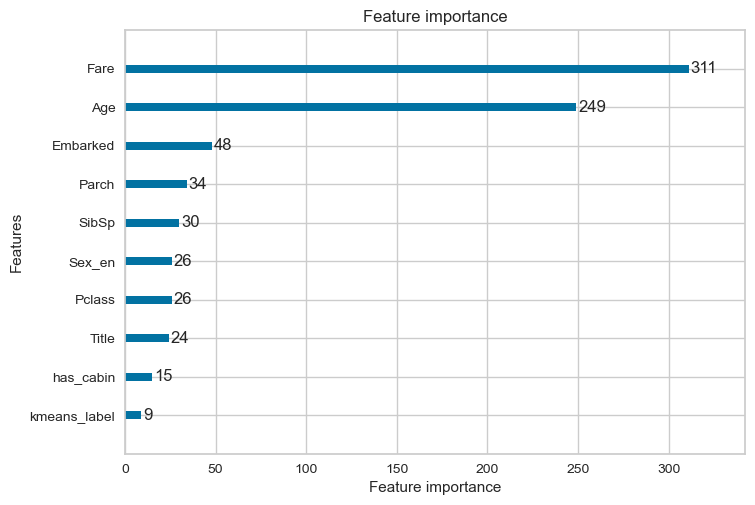

In [42]:
from lightgbm import plot_importance

plot_importance(final_model)

# Predict the test data

In [109]:
test_df_processed

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,Title,Sex_en,kmeans_label
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,Mr,0,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,Mrs,1,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,Mr,0,2
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,Mr,0,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,Mrs,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.5,0,0,A.5. 3236,8.0500,NaN,S,0,Mr,0,2
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1,Other,1,2
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,Mr,0,2
416,1308,3,"Ware, Mr. Frederick",male,27.5,0,0,359309,8.0500,NaN,S,0,Mr,0,2


In [113]:
X_test = test_df_processed.drop(['PassengerId', 'Ticket', 'Cabin', 'Name', 'Sex'], axis=1)

X_test['Embarked'] = pd.Categorical(X_test['Embarked'])
X_test['Title'] = pd.Categorical(X_test['Title'])

y_pred = final_model.predict(X_test)

In [115]:
submission_df = pd.DataFrame({'PassengerID': test_df_processed['PassengerId'], 'Survived': y_pred})

In [116]:
submission_df.to_csv("submission_titanic.csv", index=False)

# Deployment

- prepare the necessary pickle files of the models including the age imputer and clustering

In [181]:
import pickle

with open('model/pickles/kmeans.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

with open('model/pickles/final_prediction_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [154]:
test_df.iloc[10]

PassengerId                 902
Pclass                        3
Name           Ilieff, Mr. Ylio
Sex                        male
Age                         NaN
SibSp                         0
Parch                         0
Ticket                   349220
Fare                     7.8958
Cabin                       NaN
Embarked                      S
Name: 10, dtype: object

In [155]:
input_dict = eval(X_test.iloc[0].to_json())

In [156]:
input_dict

{'Pclass': 3,
 'Age': 34.5,
 'SibSp': 0,
 'Parch': 0,
 'Fare': 7.8292,
 'Embarked': 'Q',
 'has_cabin': 0,
 'Title': 'Mr',
 'Sex_en': 0,
 'kmeans_label': 2}

In [178]:
input_dict = {'Pclass': 3,
 'Age': 34.5,
 'SibSp': 0,
 'Parch': 0,
 'Fare': 7.8292,
 'Embarked': 'Q',
 'Cabin': 0,
 'Title': 'Mrdw',
 'Sex': 'female',
}

In [179]:
def kmeans_predict(df):
    feature_list = ['Sex_en', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'has_cabin']
    return kmeans.predict(df[feature_list])


def preprocess(input_dict):
    
    if input_dict['Cabin']:
        has_cabin = 1
    else:
        has_cabin = 0
    if input_dict['Sex'] == 'male':
        Sex_en = 0
    else:
        Sex_en = 1

    if input_dict['Title'] not in ['Mr', 'Miss', 'Mrs', 'Master']:
        title = "Other"
    else:
        title = input_dict['Title']

    df = pd.DataFrame({
        'Pclass': [input_dict['Pclass']],
        'Age': [input_dict['Age']],
        'SibSp':  [input_dict['SibSp']],
        'Parch':  [input_dict['Parch']],
        'Fare':  [input_dict['Fare']],
        'Embarked':  [input_dict['Embarked']],
        'has_cabin':  [has_cabin],
        'Title':  [title],
        'Sex_en':  [Sex_en],
    })

    df['kmeans_label'] = kmeans_predict(df)
    df['Embarked'] = pd.Categorical(df['Embarked'])
    df['Title'] = pd.Categorical(df['Title'])

    return df


In [180]:
final_model.predict(preprocess(input_dict))

c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Bana\anaconda3\envs\regression\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd

array([0], dtype=int64)